In [2]:
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.stats import t as student_t
from scipy import integrate
from scipy.stats import norm
from sklearn.metrics import adjusted_rand_score  
import matplotlib.pyplot as plt
import math
from typing import Callable, Tuple, List, Dict, Literal, Optional

In [3]:
from statsmodels import robust 

In [4]:
import matplotlib.pyplot as plt
import pandas as pd 

# I- Dynamic programming functions

In [4]:

QuadPiece = Tuple[float, float, float, float, float, int]
#quadpiece is a tuple containing:
#first float a = left bound of the interval
#second flat b: right bound of the interval
#3 other floats A,B,C = coefficients of the quadratic polynom on interval [a,b]: AX^2+BX=c 
#last int tau = index of last changepoint 


#algorithm 2 from appendix D 
def rfpop_algorithm2_add_Qstar_and_gamma(Qstar_pieces: List[QuadPiece], 
                                         #Q_star est représenté sous forme [ (a1,b1,A1,B1,C1,tau1), (a2,b2,A2,B2,C2,tau2), ..., ]
                                         gamma_pieces: List[QuadPiece]):

    out: List[QuadPiece] = []
    i = 0
    j = 0
    while i < len(Qstar_pieces) and j < len(gamma_pieces):
        pa, pb, pA, pB, pC, p_tau = Qstar_pieces[i]
        ga, gb, gA, gB, gC, g_tau = gamma_pieces[j]

        #new interval 
        a = max(pa, ga)
        b = min(pb, gb)
        
        # sum of Q_star and gamma on the new interval
        newA = pA + gA
        newB = pB + gB
        newC = pC + gC
        # tau comes from Q* (p_tau) 
        out.append((a, b, newA, newB, newC, p_tau))
        # avancer indices selon bornes
        if abs(b - pb) < 1e-12:
            i += 1
        if abs(b - gb) < 1e-12:
            j += 1
        # to avoid infinite loop
        if (i < len(Qstar_pieces) and j < len(gamma_pieces)) and a >= b - 1e-14 and abs(b - Qstar_pieces[i][1]) > 1e-12 and abs(b - gamma_pieces[j][1]) > 1e-12:
            break
    # to do as they say on page 12 and merge identical neighbouring intervals
    if not out:
        return []
    merged: List[QuadPiece] = [out[0]]
    for pc in out[1:]:
        a,b,A,B,C,tau = pc
        ma,mb,mA,mB,mC,mtau = merged[-1]
        if (abs(A - mA) < 1e-14 and abs(B - mB) < 1e-14 and abs(C - mC) < 1e-9 and tau == mtau and abs(a - mb) < 1e-9):
            merged[-1] = (ma, b, mA, mB, mC, mtau)
        else:
            merged.append(pc)
    return merged



In [5]:
#algorithm 3 from pseudocode 
def rfpop_algorithm3_min_over_theta(Qt_pieces: List[QuadPiece]):
    best_val = float('inf')
    best_tau = 0
    for (a,b,A,B,C,tau) in Qt_pieces:
        # computing min of Q_t(theta) over segment (a,b]
        if abs(A) < 1e-16:
            #if the coefficient associated with x^2 of the quadratic function is =0 then the function is linear (B!=0) or constant (B=0)
            #hence in this case min value of Q_t(theta) is on the boundaries of the segment
            left = a + 1e-12 #because segment does not contain a 
            right = b
            vleft = A*left*left + B*left + C
            vright = A*right*right + B*right + C
            theta_star = left if vleft <= vright else right
        else: #if A!=0 then Q_t(theta) =A theta^2 + B theta + C on segment (a,b] 
            #so minimizer is -B/2A   (each quadratic is assumed convex, not concave so not a maximizer)
            theta_star = -B / (2.0 * A)
            #we need to ensure the minimizer is in (a,b]
            if theta_star <= a: 
                theta_star = a + 1e-12
            elif theta_star > b:
                theta_star = b
        val = A*theta_star*theta_star + B*theta_star + C
        if val < best_val:
            best_val = val
            best_tau = tau
    return float(best_val), int(best_tau)

In [6]:
#algorithm 4

def rfpop_algorithm4_prune_compare_to_constant(Qt_pieces: List[QuadPiece],
                                               Qt_val: float, #Qt_val + beta = the constant C in appendix
                                               beta: float,
                                               t_index_for_new: int):
   
    thr = Qt_val + beta
    out: List[QuadPiece] = []

    #goes through the Nt intervals of Qt
    for (a,b,A,B,C,tau) in Qt_pieces:
        #finds the roots of Q_t(x) - C ie the roots of A x^2 + B x + (C - thr) = 0 on [a,b]
        # BEWARE: source of confuction: thr is the equivalent of the constant C in the pseudocode of the paper
        # C is the last coefficient of the quadratic function, not the constant C defined in the pseudocode 
        roots: List[float] = []
        if abs(A) < 1e-16:
            # if the quadratic function is linear or constant: B x + (C - thr) = 0
            if abs(B) > 1e-16:
                x = -(C - thr) / B
                #we need to ensure root x is in interval [a,b] otherwise we don't care about it 
                if x + 1e-12 >= a and x - 1e-12 <= b:
                    x_clamped = max(min(x, b), a) #to ensure the root is indeed within the interval and have no problems of numerical errors later: we need to sort the roots it could do weird things later if we don't do that
                    roots.append(x_clamped)
        else:
            #if the function is indeed quadratic we compute delta and roots 
            D = B*B - 4.0*A*(C - thr)
            if D >= -1e-14:
                D = max(D, 0.0)
                sqrtD = math.sqrt(D)
                x1 = (-B - sqrtD) / (2.0*A)
                x2 = (-B + sqrtD) / (2.0*A)
                for x in (x1, x2):
                    if x + 1e-12 >= a and x - 1e-12 <= b:
                        x_clamped = max(min(x, b), a)
                        # avoid duplicates if delta D = 0 we get 2 times the same root 
                        if not any(abs(x_clamped - r) < 1e-9 for r in roots):
                            roots.append(x_clamped)
        roots.sort()
        # create vector [a, r1, r2,  b]
        breaks = [a] + roots + [b]
        for k in range(len(breaks)-1):
            lo = breaks[k]
            hi = breaks[k+1]
            mid = (lo + hi) / 2.0
            #here we evaluate the polynom A*mid*mid + B*mid + C - thr on each subsegment [a,root_1], [root_1,root_2],[root_2,b]
            #on each of these subsegment this polynom has the same sign as each bound of a subsegment is a root 
            #so we can pick an arbitrary value like the middle to see the sign of the polynom on this subsegment
            val_mid = A*mid*mid + B*mid + C - thr 

            #if polynom is negative then Q_t(theta)<constant so we keep Q_t(theta) = A*theta^2 + B*theta + C
            if val_mid <= 1e-12:
                # keep Q_t on this subsegment
                out.append((lo, hi, A, B, C, tau))
            else:
                # keep constant thr in this subsegment and set a changepoint at t_index_for_new 
                out.append((lo, hi, 0.0, 0.0, thr, t_index_for_new))
    # fusionner adjacences égales
    if not out:
        return []
    merged: List[QuadPiece] = [out[0]]
    for pc in out[1:]:
        a,b,A,B,C,tau = pc
        ma,mb,mA,mB,mC,mtau = merged[-1]
        if (abs(A - mA) < 1e-14 and abs(B - mB) < 1e-14 and abs(C - mC) < 1e-9 and tau == mtau and abs(a - mb) < 1e-9):
            merged[-1] = (ma, b, mA, mB, mC, mtau)
        else:
            merged.append(pc)
    return merged


In [7]:
#algorithm 1
def rfpop_algorithm1_main(y: List[float], gamma_builder, beta: float):

    y_arr = np.asarray(y, dtype=float)
    n = len(y_arr)

    lo = float(np.min(y_arr)) - 1.0 #we add -1 and +1 to ensure there is no numeric problem with python approximations for foats 
    hi = float(np.max(y_arr)) + 1.0
    Qstar = [(lo, hi, 0.0, 0.0, 0.0, 0)]  # Q*_1
    cp_tau = [0] * n
    Qt_vals = [0.0] * n
    for t_idx in range(n):
        # Sub-routine 2 : Qt = Q*_t + gamma(y_t)
        gamma_pcs = gamma_builder(float(y_arr[t_idx]), t_idx)
        Qt_pcs = rfpop_algorithm2_add_Qstar_and_gamma(Qstar, gamma_pcs)
        # Sub-routine 3 : min over theta Qt
        Qt_val, tau_t = rfpop_algorithm3_min_over_theta(Qt_pcs)
        cp_tau[t_idx] = tau_t
        Qt_vals[t_idx] = Qt_val
        # Sub-routine 4 : compute Q*_{t+1}
        Qstar = rfpop_algorithm4_prune_compare_to_constant(Qt_pcs, Qt_val, beta, t_idx)
    return cp_tau, Qt_vals, Qstar



In [8]:

QuadPiece = Tuple[float, float, float, float, float, int]
INF = 1e18  # borne pratique pour "infty"
EPS = 1e-12

def gamma_builder_L2(y: float, tau_for_new: int) -> List[QuadPiece]:
    """
    gamma(y,theta) = (y - theta)^2 = theta^2 - 2*y*theta + y^2
    Single quadratic piece on (-INF, INF].
    """
    A = 1.0
    B = -2.0 * y
    C = y * y
    return [(-INF, INF, A, B, C, tau_for_new)]

def gamma_builder_biweight(y: float, K: float, tau_for_new: int) -> List[QuadPiece]:
    """ :
      gamma(y,theta) = (y-theta)^2   if |y-theta| <= K
                      = K^2         otherwise
    Can be defined as 3 different quadratic functions over 3 segments :
      (-INF, y-K]       : constant K^2
      (y-K, y+K]        : quadratic (y-theta)^2
      (y+K, INF)        : constant K^2
    """
    A_q = 1.0
    B_q = -2.0 * y
    C_q = y * y
    constC = float(K * K)
    return [
        (-INF, y - K, 0.0, 0.0, constC, tau_for_new),
        (y - K, y + K, A_q, B_q, C_q, tau_for_new),
        (y + K, INF, 0.0, 0.0, constC, tau_for_new)
    ]


def gamma_builder_huber(y: float, K: float, tau_for_new: int) -> List[QuadPiece]:
    """
    Huber loss with threshold K:
      gamma(y,theta) = (y-theta)^2                     if |y-theta| <= K
                      = 2*K*|y-theta| - K^2           if |y-theta| > K
    
    Can be defined as 3 quadratic functions over 3 segments  
    (-INF, y-K] :  2*K*(y-theta) - K^2 = -2K*theta + (2K*y - K^2)
    (y-K, y+K]: (y-theta)^2 = theta^2 - 2y theta + y^2
    (y+K, INF): 2*K*(theta-y) - K^2 = 2K*theta + (-2K*y - K^2)
    """
    # central quadratic
    A_q = 1.0
    B_q = -2.0 * y
    C_q = y * y
    # left linear: B_left * theta + C_left  where B_left = -2K, C_left = 2K*y - K^2
    B_left = -2.0 * K
    C_left = 2.0 * K * y - K * K
    # right linear: B_right * theta + C_right where B_right = 2K, C_right = -2K*y - K^2
    B_right = 2.0 * K
    C_right = -2.0 * K * y - K * K
    return [
        (-INF, y - K, 0.0, B_left, C_left, tau_for_new),   # linear = A=0
        (y - K, y + K, A_q, B_q, C_q, tau_for_new),       # quadratic
        (y + K, INF, 0.0, B_right, C_right, tau_for_new) # linear = A=0
    ]

def gamma_builder_L1(y: float, tau_for_new: int) -> List[QuadPiece]:
    """
    L1 loss: gamma(y,theta) = |y - theta|
    Piecewise-linear
      (-INF, y) :  y - theta = (-1)*theta + y
      (y, INF): theta - y = (+1)*theta + (-y)

    """
    # left piece: (-INF, y] -> -theta + y  => A=0, B=-1, C=y
    # right piece: (y, INF] -> theta - y  => A=0, B=1,  C=-y
    return [
        (-INF, y, 0.0, -1.0, float(y), tau_for_new),
        (y, INF, 0.0,  1.0, float(-y), tau_for_new)
    ]


## II - Data for experiments 

In [9]:


def generate_scenarios():

    np.random.seed(42) 

    # Fonction auxiliaire pour le bruit t-student
    def t_noise(n, df=5, sigma=1.0):
        return np.random.standard_t(df, size=n) * sigma

    #scenario 1
    n1 = 2048
    t = np.arange(n1) / n1
    pos = np.array([0.1, 0.13, 0.15, 0.23, 0.25, 0.40, 0.44, 0.65, 0.76, 0.78, 0.81])
    h = np.array([4, -5, 3, -4, 5, -4.2, 2.1, 4.3, -3.1, 2.1, -4.2])
    sig1 = np.zeros(n1)
    for p, hi in zip(pos, h):
        sig1[int(p * n1):] += hi
    sig1 = sig1 * 3.5 
    y1 = sig1 + t_noise(n1, df=5, sigma=5.0) 

    #Scenario 2
    n2 = 512
    sig2 = np.zeros(n2)
    segments_fms = [
        (0, 200, -0.2), (200, 220, 0.2), (220, 240, 1.2), (240, 260, -0.8),
        (260, 280, 0.5), (280, 400, -0.1), (400, 420, 0.8), (420, 512, -0.3)
    ]
    for start, end, val in segments_fms:
        sig2[start:end] = val
    y2 = sig2 + t_noise(n2, df=5, sigma=0.3)


    # --- Scenario 2'
    # same signal but less noise
    y2_prime = sig2 + t_noise(n2, df=5, sigma=0.2)

    #Scenario 3
    # short and long segments
    n3 = 512
    sig3 = np.zeros(n3)
    curr = 0
    mu = 0
    #alternate randomly between long and short segments 
    while curr < n3:
        length = np.random.choice([10, 20, 80, 100])
        val = np.random.normal(0, 2)
        end = min(curr + length, n3)
        sig3[curr:end] = val
        curr = end

    y3 = sig3 + t_noise(n3, df=5, sigma=0.3)


    #Scenario 4 saw tooth 
    n4 = 240
    sig4 = np.zeros(n4)
    n_teeth = 10
    len_tooth = n4 // n_teeth 
    for i in range(n_teeth):
        if i % 2 == 1:
            sig4[i*len_tooth : (i+1)*len_tooth] = 1.0
    y4 = sig4 + t_noise(n4, df=5, sigma=0.3)

    #Scenario 5: Stairs 
    n5 = 150
    sig5 = np.zeros(n5)
    n_steps = 10
    len_step = n5 // n_steps 
    for i in range(n_steps):
        sig5[i*len_step : (i+1)*len_step] = (i + 1) * 1.5
    # Bruit
    y5 = sig5 + t_noise(n5, df=5, sigma=0.3)

    dic1 = {
        "Scenario 1": y1,
        "Scenario 2": y2,
        "Scenario 2'": y2_prime,
        "Scenario 3": y3,
        "Scenario 4": y4,
        "Scenario 5": y5}
    dic2 = {
        "Scenario 1": sig1,
        "Scenario 2": sig2,
        "Scenario 2'": sig2,
        "Scenario 3": sig3,
        "Scenario 4": sig4,
        "Scenario 5": sig5}
    return dic1,dic2



data, true_signals = generate_scenarios()


## III- Reproducing the experiments 

We should pick K and beta optimally as in the paper: 
$$K = \begin{cases}
                3 \hat \sigma \quad \text{for the biweight loss}, \\
                1.345 \hat \sigma \quad \text{for the huber loss}
            \end{cases} $$


Where $\hat \sigma$ is the median absolute deviation of the differenced time series. 


$$ \beta = 2 \hat \sigma^2\text{log}(n) \mathbb E(\phi(Z)^2)$$

Where $\phi$ is the gradient of the loss function and $Z \sim \mathcal N(0,1)$

#### Important: 
- the ratio $\beta/K$ represents the minimum length of segments chosen by the algorithm. 
- when data is such that the ratio $\beta/K$ is too small, the model will overfit the data and detect too many changepoints. In particular, in extreme cases, \$beta/K$ can be lower than 1 and then the algorithms will consider simple outliers as a segment, resulting in many changepoints. 
- as a result, we consider that if $\beta/K \leq len(y)/100$, the minimum segment size will be too small. In that case, we manually adjust the $\beta$ so that $\beta = Klen(y)/100$. 

In [10]:
#function to compute parameter K
def compute_loss_bound_K(y,
             loss: Literal['huber','biweight']):
    ys =pd.Series(y)
    mad = robust.mad(ys.diff().dropna())
    if loss == "biweight":
        return 3*mad
    elif loss == 'huber':
        return 1.345*mad 



#functions necessary to compute optimal beta according to schwarz information criteria 
#we now need to introduce a few auxiliary functions to compute the optimal beta from the paper:
#indeed we need to compute E(phi(Z)^2) where phi is the gradient of the loss function used: this implies doing numerical approximations

# Huber loss gradient definition for integration
def huber_gradient(z, K):
    return z if abs(z) <= K else math.copysign(K, z)

# biweight loss gradient definition for integration
def biweight_gradient(z, K):
    return z if abs(z) <= K else 0


# function to integrate that will be used to approximate E(phi(Z)^2)
def integrand_phi2(phi_func, z, K):
    return (phi_func(z, K)**2) * norm.pdf(z)



# def compute_E_phi2(phi_func, #either huber_gradient or biweight_gradient 
#                    K):
#     E_phi2, _ = integrate.quad(lambda z: integrand_phi2(phi_func, z, K), -np.inf, np.inf,
#                                 epsabs=1e-9, epsrel=1e-9, limit=200)
    
#     return float(E_phi2)

def compute_penalty_beta(y,
                         loss: Literal['huber','biweight','l2','l1']
                         ):
    
    """
    page 16 of the paper: optimal beta according to schwarz information criteria is beta = 2 \hat{\sigma}^2 log(n) E(phi(Z)^2)
    where:
    \hat{\sigma} = median absolute deviation of the differentiated time series y = estimator of variance of the noise
    n = length of time series 
    phi = gradient of the loss function used 
    Z = a N(0,I)

    for L2 loss p(z) = z^2/2, phi(z)=z so E(phi(Z)^2) = E(Z^2) = 1
    for huber and biweight loss, E(phi(Z)^2) is approximated numerically 
    for L1 loss we can't apply the formula of the paper as E(phi(Z)^2) = 0 so we arbitrarly pick beta = log(n)
    """
    ys =pd.Series(y)
    mad = robust.mad(ys.diff().dropna())

    if loss == 'l2':
        return 2*mad*mad*np.log(len(y))

    elif loss == 'huber':

        K = compute_loss_bound_K(y,'huber')

        E_phi2, _ = integrate.quad(lambda z: integrand_phi2(huber_gradient, z, K), -np.inf, np.inf,
                                epsabs=1e-9, epsrel=1e-9, limit=200)
        
        return 2*mad*mad*np.log(len(y))*float(E_phi2)
    
    elif loss == 'biweight':
        
        K = compute_loss_bound_K(y,'biweight')

        E_phi2, _ = integrate.quad(lambda z: integrand_phi2(biweight_gradient, z, K), -np.inf, np.inf,
                                epsabs=1e-9, epsrel=1e-9, limit=200)
        
        return 2*mad*mad*np.log(len(y))*float(E_phi2)
    
    elif loss == 'l1':
        return np.log(len(y))


## Without the clipping rule for $\beta/K$

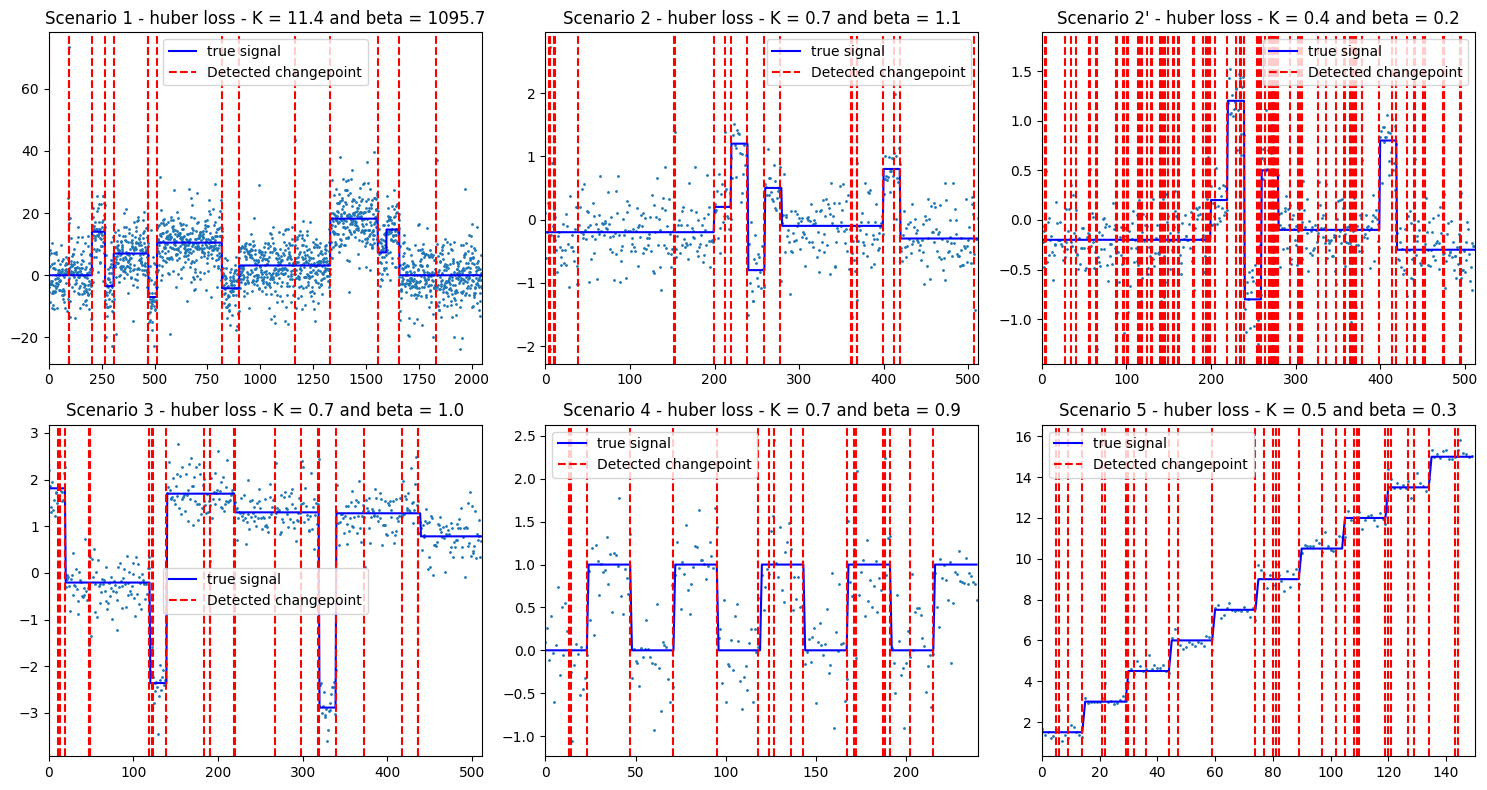

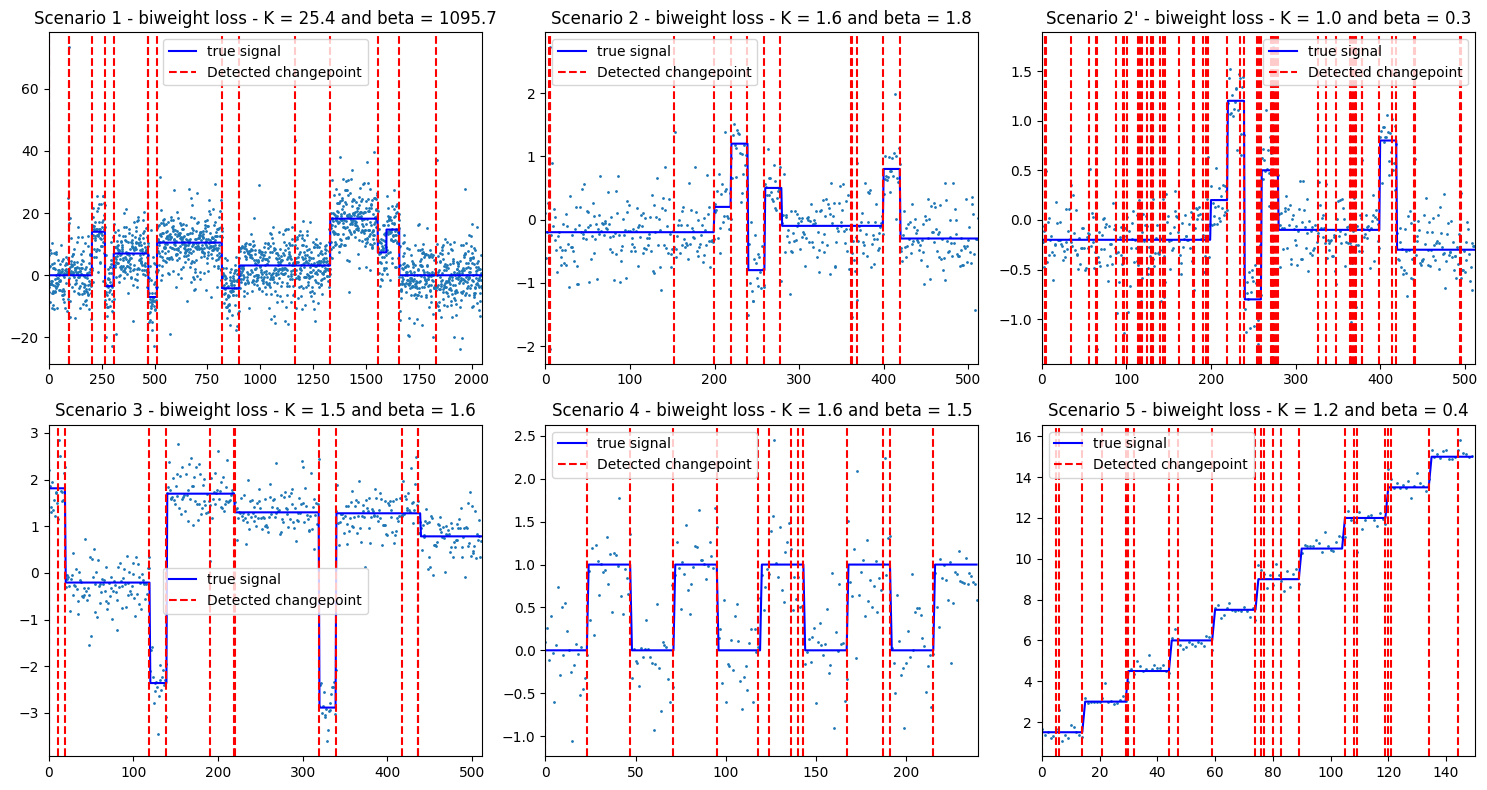

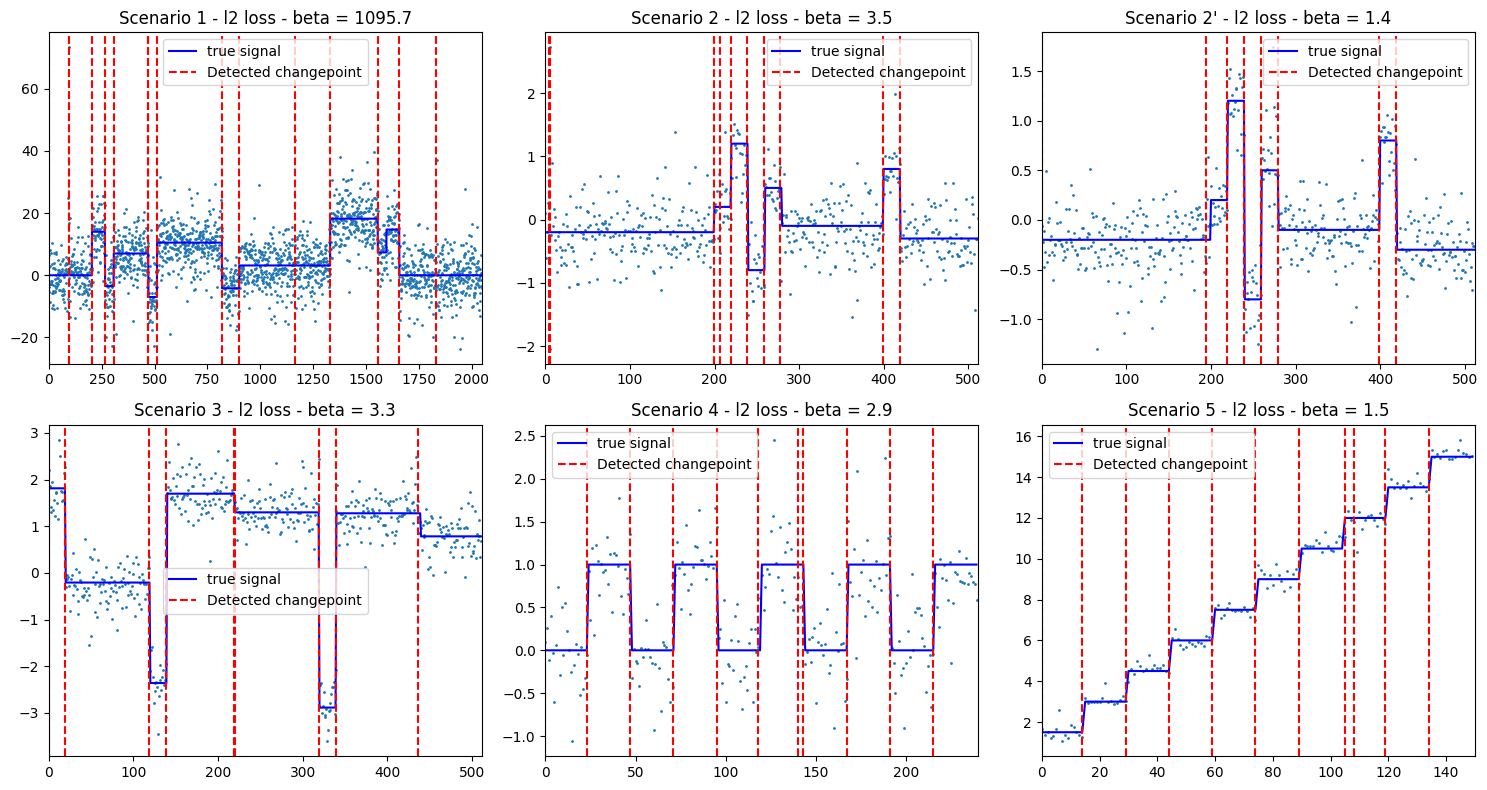

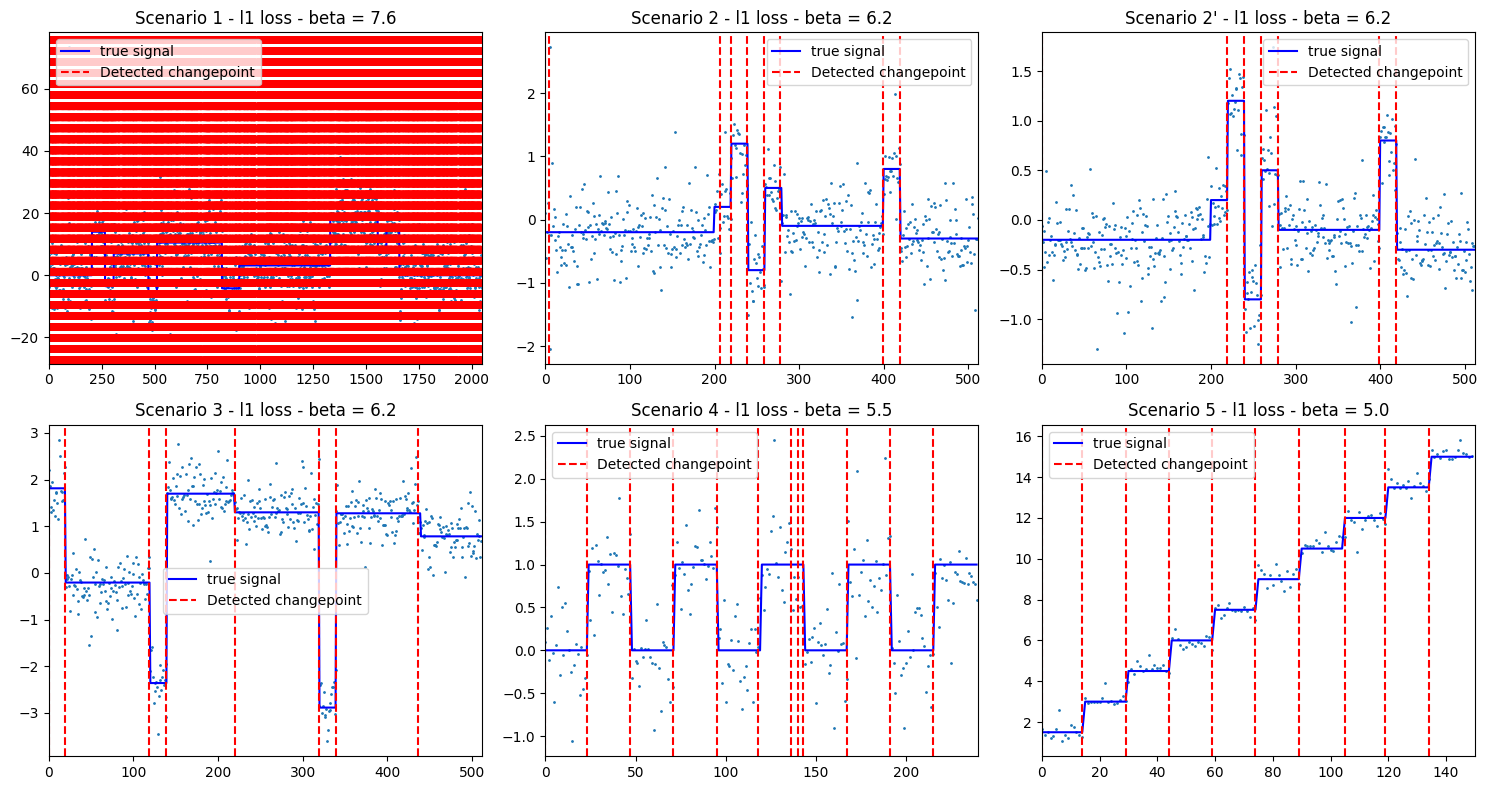

In [11]:

for loss in ['huber','biweight','l2','l1']:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()



    scenario_names = ["Scenario 1", "Scenario 2", "Scenario 2'", 
                        "Scenario 3", "Scenario 4", "Scenario 5"]

    for i, name in enumerate(scenario_names):
        y = data[name]
        true_sig = true_signals[name]
        beta = compute_penalty_beta(y,loss)
        K=compute_loss_bound_K(y,loss)



        cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_L2(y_t, t), beta)


        ax = axes[i]

        ax.plot(y, '.', markersize=2)
        ax.plot(true_sig, label = 'true signal',color = 'blue')
        changepoints = np.unique(cp_tau)
    
        for cp in changepoints:
            
            # On trace une ligne rouge pointillée à chaque changepoint
            ax.axvline(x=cp, color='r', linestyle='--', label='Detected changepoint' if cp == changepoints[0] else "")
        if not K:
            ax.set_title(f'{name} - {loss} loss - beta = {round(beta,1)}')
        else:
            ax.set_title(f'{name} - {loss} loss - K = {round(K,1)} and beta = {round(beta,1)}')
        ax.set_xlim(0, len(y))
        ax.legend()
        

    plt.tight_layout()
    plt.show()

We can indeed see that the Huber and biweight losses are not that robust when $\beta/K$ is too small (for instance scenario 3 of the biweight loss with a ratio <1). When the ratio is too small, unbounded losses like $\ell_2$ and $\ell_1$ even perform better. 

## Avec ajout de la règle de clipping de $\beta/K$

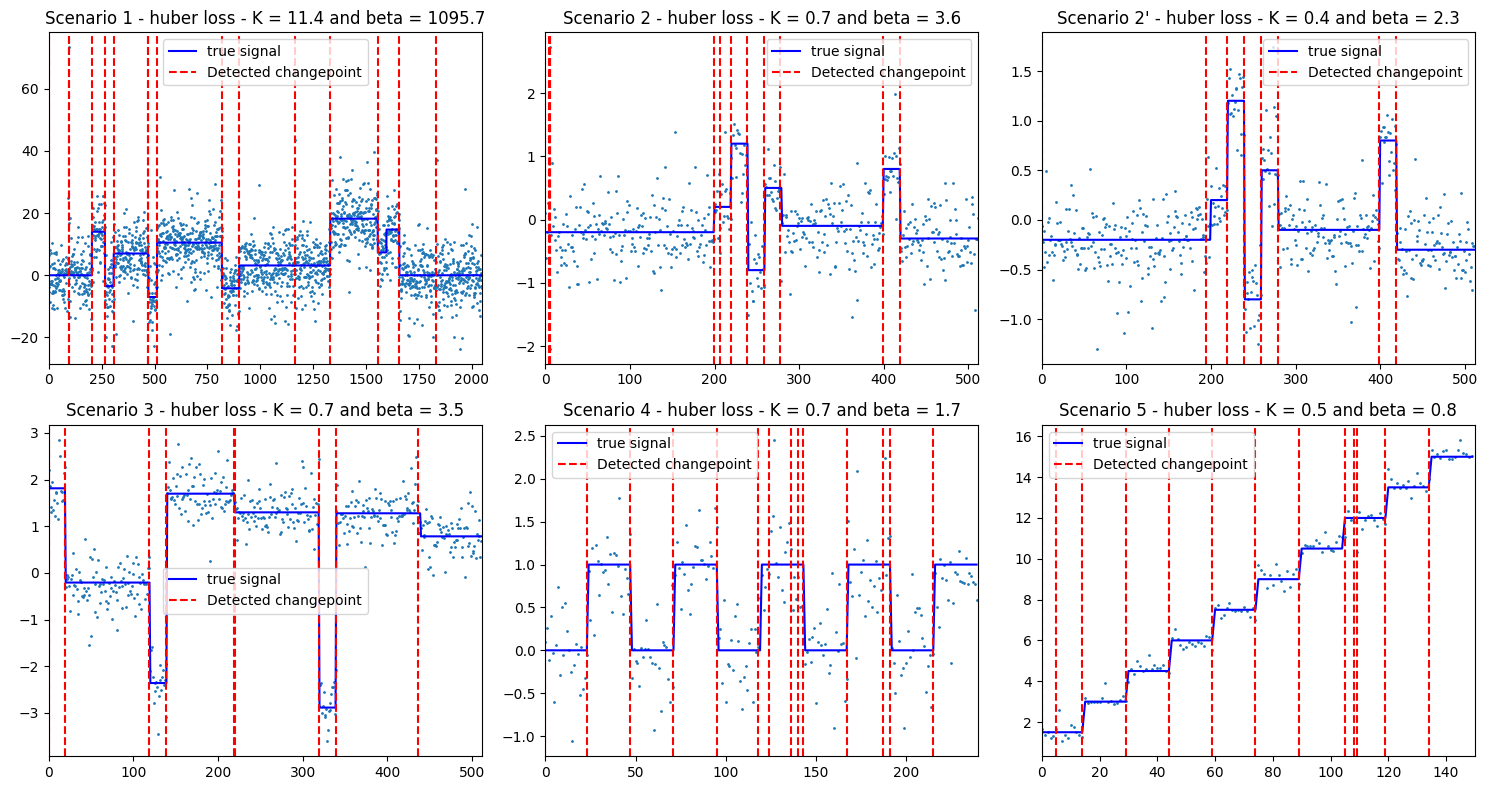

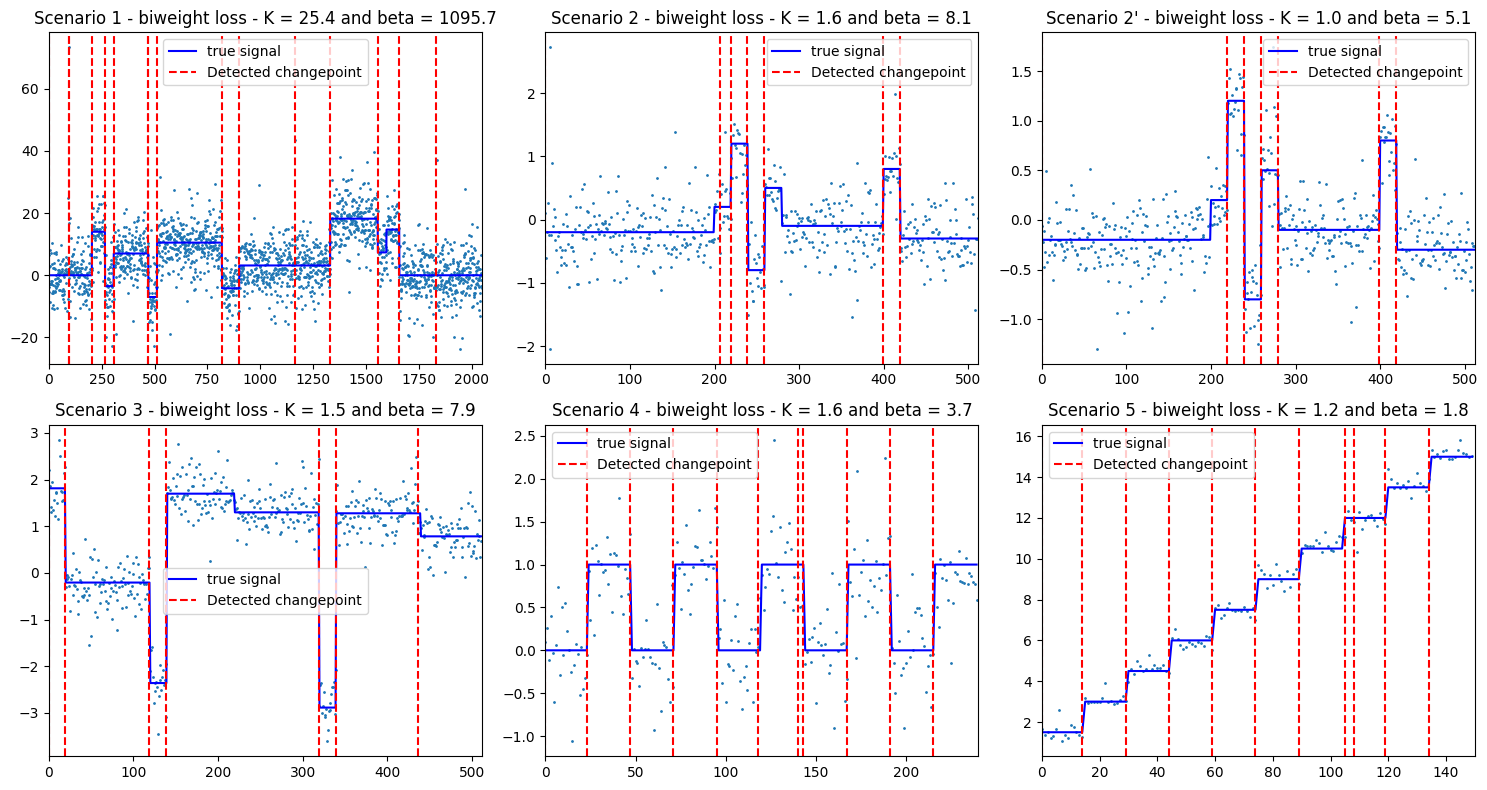

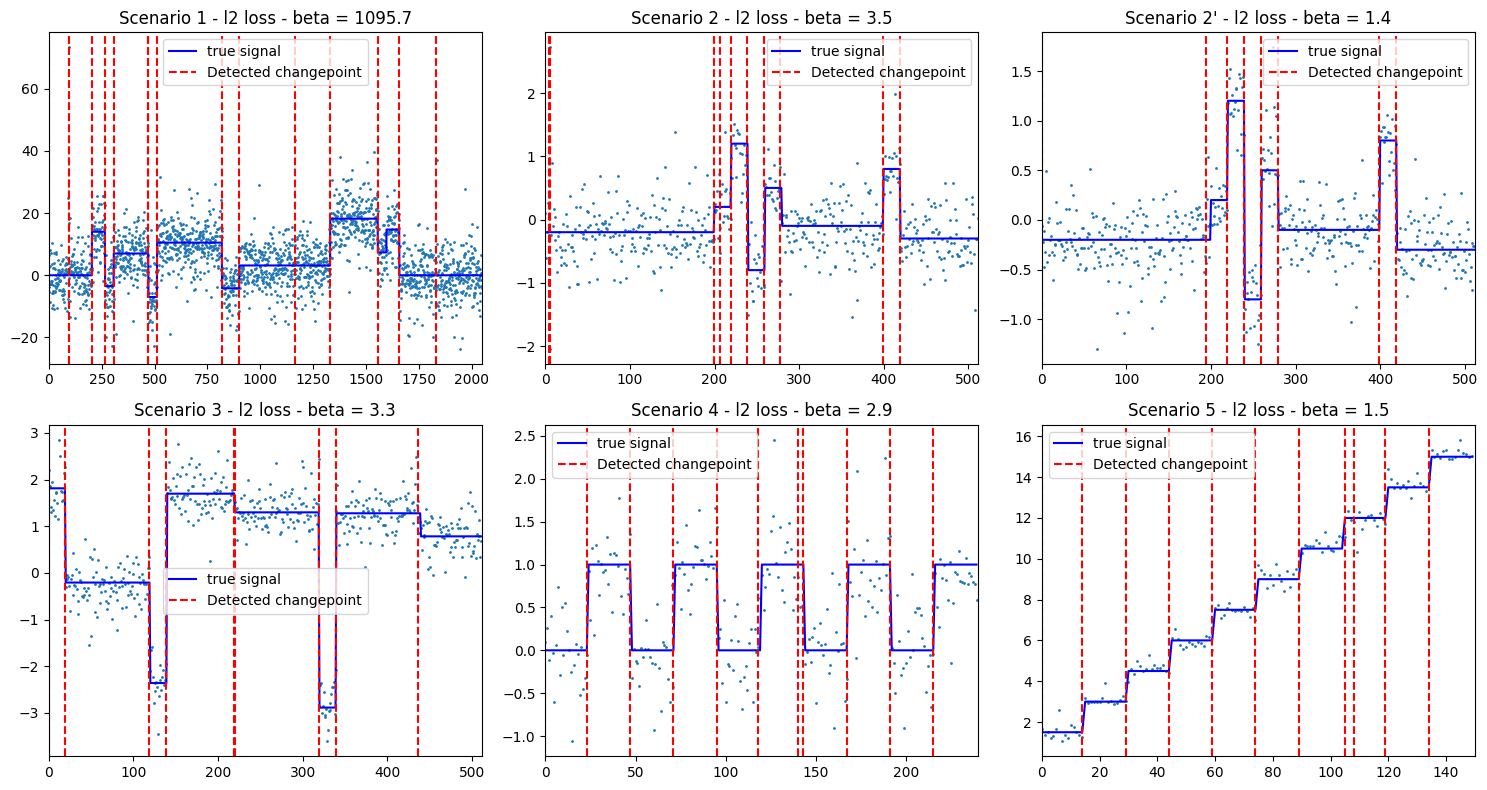

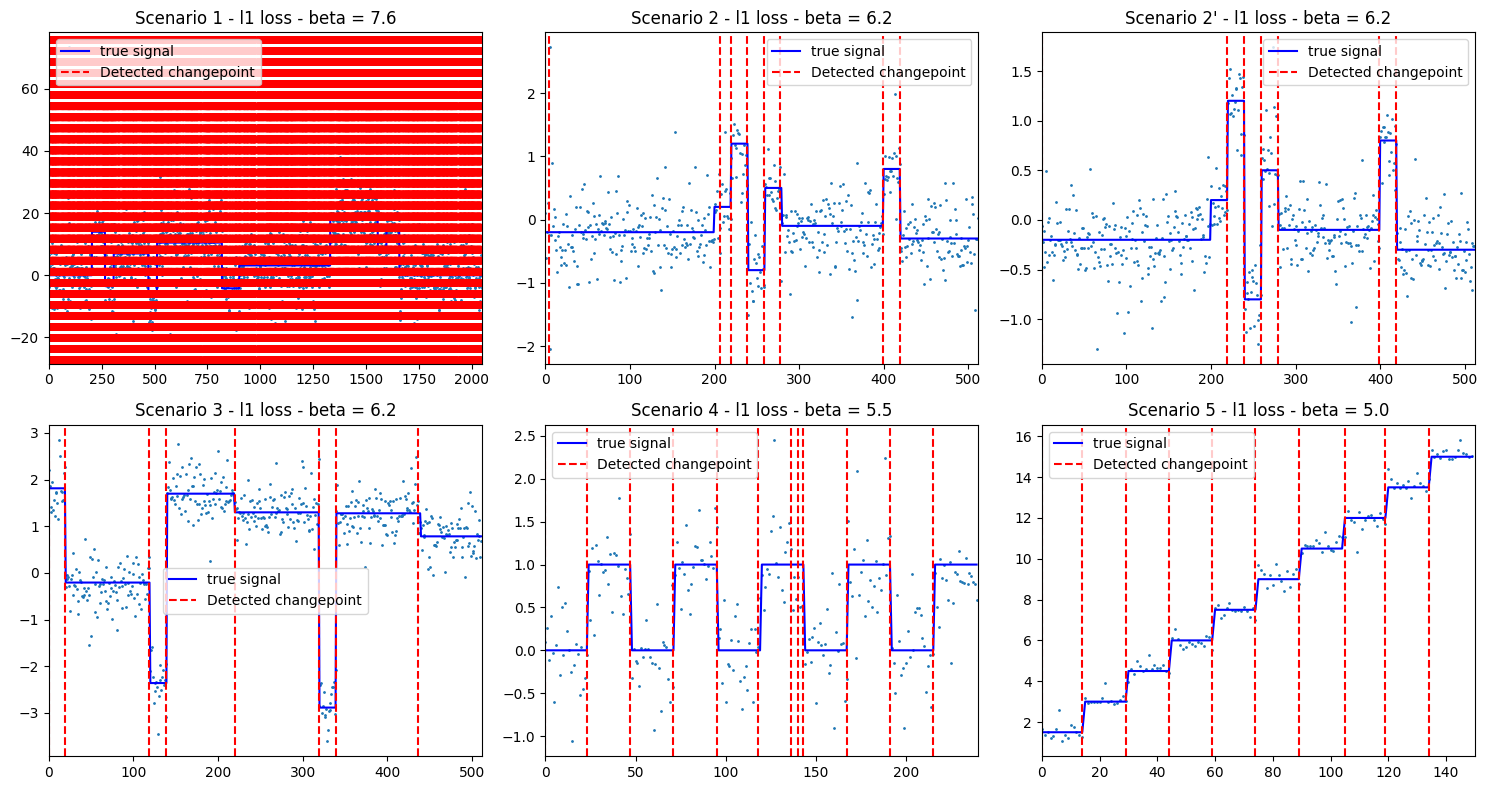

In [12]:

for loss in ['huber','biweight','l2','l1']:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()



    scenario_names = ["Scenario 1", "Scenario 2", "Scenario 2'", 
                        "Scenario 3", "Scenario 4", "Scenario 5"]

    for i, name in enumerate(scenario_names):
        y = data[name]
        true_sig = true_signals[name]
        beta = compute_penalty_beta(y,loss)
        K=compute_loss_bound_K(y,loss)

        if K:
            if beta/K < len(y)/100:
                beta = K*len(y)/100


        cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_L2(y_t, t), beta)


        ax = axes[i]

        ax.plot(y, '.', markersize=2)
        ax.plot(true_sig, label = 'true signal',color = 'blue')
        changepoints = np.unique(cp_tau)
    
        for cp in changepoints:
            
            # On trace une ligne rouge pointillée à chaque changepoint
            ax.axvline(x=cp, color='r', linestyle='--', label='Detected changepoint' if cp == changepoints[0] else "")
        if not K:
            ax.set_title(f'{name} - {loss} loss - beta = {round(beta,1)}')
        else:
            ax.set_title(f'{name} - {loss} loss - K = {round(K,1)} and beta = {round(beta,1)}')
        ax.set_xlim(0, len(y))
        ax.legend()
        

    plt.tight_layout()
    plt.show()

We can see a real improvement with this clipping rule.

# Cross Validation

We cross validate beta and K

In [13]:
def cv_biweight_paper(
    y: np.ndarray,
    true_signal: Optional[np.ndarray] = None,
    beta_range: Optional[np.ndarray] = None,
    K_range: Optional[np.ndarray] = None,
    criterion: Literal['penalized_cost', 'ari', 'raw_cost_bic'] = 'penalized_cost',
    apply_clipping: bool = False,
    verbose: bool = True
) -> dict:
    """
    Cross-validation pour la biweight loss selon le papier Fearnhead & Rigaill.

    Cette fonction explore les paramètres β et K autour des valeurs recommandées
    par le papier et peut appliquer la règle de clipping β/K ≥ n/100.

    Parameters:
    -----------
    y : np.ndarray
        Série temporelle
    true_signal : np.ndarray, optional
        Vrai signal (requis pour le critère 'ari')
    beta_range : np.ndarray, optional
        Grille de valeurs pour β (par défaut: multiplicateurs de β théorique)
    K_range : np.ndarray, optional
        Grille de valeurs pour K (par défaut: multiplicateurs de K théorique)
    criterion : str
        Critère d'optimisation:
        - 'penalized_cost': Coût pénalisé Qt_vals[-1] = Σ C(seg) + (m+1)β (défaut)
          C'est le critère naturel du papier, β contrôle déjà la complexité
        - 'ari': Adjusted Rand Index (nécessite true_signal) - critère oracle
        - 'raw_cost_bic': Coût brut (sans β) + log(n) * n_changepoints
          Utile si on veut comparer différentes valeurs de β sur un même critère
    apply_clipping : bool
        Si True, applique la règle de clipping β = max(β, K*n/100)
    verbose : bool
        Affiche les informations de progression

    Returns:
    --------
    dict : Résultats de la CV incluant best_beta, best_K, best_ratio

    Notes:
    ------
    Le coût total (Qt_vals[-1]) retourné par RFPOP est:
        Q = Σ C(segment_i) + (n_segments) × β

    Où C(segment) = min_θ Σ γ(yi; θ) est la somme des pertes sur le segment.

    Donc Qt_vals[-1] inclut DÉJÀ la pénalité pour le nombre de changepoints via β.
    C'est pourquoi 'penalized_cost' est le critère par défaut.
    """
    n = len(y)

    # Paramètres théoriques du papier
    ys = pd.Series(y)
    sigma_hat = robust.mad(ys.diff().dropna())  # Estimateur de σ

    K_paper = compute_loss_bound_K(y, 'biweight')
    beta_paper = compute_penalty_beta(y, 'biweight')
    

    # Ratio théorique
    ratio_paper = beta_paper / K_paper


    #gridsearch
    if beta_range is None:
        # addition autour de β théorique
        beta_range = np.linspace(0.1* beta_paper, 3.0* beta_paper, num=30)

    if K_range is None:
        # Multiplicateurs autour de K théorique
        K_range = np.linspace(0.1* K_paper, 10.0* K_paper, num=30)


    # Grid search
    results = []

    if verbose:
        print(f"\nExploration de {len(beta_range)} × {len(K_range)} = {len(beta_range)*len(K_range)} combinaisons...")

    for beta in beta_range:
        for K in K_range:
            # Appliquer le clipping si demandé
            beta_used = beta
            if apply_clipping and beta/K < n/100:
                beta_used = K * n / 100

            try:
                # Exécuter RFPOP avec biweight
                gamma_builder = lambda y_t, t: gamma_builder_biweight(y_t, K, t)
                cp_tau, Qt_vals, _ = rfpop_algorithm1_main(list(y), gamma_builder, beta_used)

                changepoints = np.unique(cp_tau)
                n_cp = len(changepoints) - 1  # nombre de changepoints (excluant 0)
                n_segments = len(changepoints)  # nombre de segments

                # Coût total pénalisé (inclut déjà β × n_segments)
                penalized_cost = Qt_vals[-1]

                # Coût brut (sans les pénalités β)
                # raw_cost = penalized_cost - n_segments * β
                raw_cost = penalized_cost - n_segments * beta_used

                ratio = beta_used / K

                # Calculer le score selon le critère
                if criterion == 'penalized_cost':
                    # Utilise directement le coût pénalisé du papier
                    # C'est le critère naturel: β contrôle déjà le compromis fit/complexité
                    score = penalized_cost

                elif criterion == 'raw_cost_bic':
                    # BIC sur le coût brut: permet de comparer différents β équitablement
                    score = raw_cost + np.log(n) * n_cp

                results.append({
                    'beta_orig': beta,
                    'beta_used': beta_used,
                    'K': K,
                    'ratio': ratio,
                    'clipped': beta_used != beta,
                    'penalized_cost': penalized_cost,
                    'raw_cost': raw_cost,
                    'n_changepoints': n_cp,
                    'n_segments': n_segments,
                    'score': score,
                    'cp_tau': cp_tau,
                    'changepoints': changepoints
                })

            except Exception as e:
                if verbose:
                    print(f"  Erreur pour β={beta:.2f}, K={K:.2f}: {e}")

    # Trouver les meilleurs paramètres
    best_idx = np.argmin([r['score'] for r in results])
    best = results[best_idx]

    return {
        'best_beta': best['beta_used'],
        'best_K': best['K'],
        'best_ratio': best['ratio'],
        'best_score': best['score'],
        'best_n_cp': best['n_changepoints'],
        'best_n_segments': best['n_segments'],
        'best_penalized_cost': best['penalized_cost'],
        'best_raw_cost': best['raw_cost'],
        'best_changepoints': best['changepoints'],
        'best_cp_tau': best['cp_tau'],
        'all_results': results,
        'paper_params': {
            'beta': beta_paper,
            'K': K_paper,
            'ratio': ratio_paper,
            'sigma_hat': sigma_hat
        },
        'criterion': criterion
    }

In [14]:
def plot_cv_biweight_results(cv_result: dict, y: np.ndarray, true_signal: np.ndarray, 
                              title: str = "CV Biweight - Résultats"):
    """
    Visualise les résultats de la CV biweight avec plusieurs graphiques.
    
    Le coût affiché est le coût pénalisé Qt_vals[-1] qui inclut déjà β×n_segments.
    """
    results = cv_result['all_results']
    paper = cv_result['paper_params']
    n = len(y)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Signal avec changepoints détectés
    ax1 = axes[0, 0]
    ax1.plot(y, '.', markersize=2, alpha=0.5, label='Données')
    ax1.plot(true_signal, 'b-', linewidth=2, label='Vrai signal')
    for i, cp in enumerate(cv_result['best_changepoints']):
        ax1.axvline(x=cp, color='r', linestyle='--', alpha=0.7,
                   label='CP détectés' if i == 0 else "")
    ax1.set_title(f"β={cv_result['best_beta']:.2f}, K={cv_result['best_K']:.2f}, "
                  f"Ratio={cv_result['best_ratio']:.2f}, N_CP={cv_result['best_n_cp']}")
    ax1.legend(loc='upper right')
    ax1.set_xlim(0, n)
    
    # 2. Heatmap Score vs (β, K)
    ax2 = axes[0, 1]
    df = pd.DataFrame(results)
    pivot = df.pivot_table(values='score', index='K', columns='beta_used', aggfunc='mean')
    im = ax2.imshow(pivot.values, aspect='auto', cmap='viridis_r', origin='lower')
    ax2.set_xticks(range(len(pivot.columns)))
    ax2.set_xticklabels([f'{x:.1f}' for x in pivot.columns], rotation=45, fontsize=8)
    ax2.set_yticks(range(len(pivot.index)))
    ax2.set_yticklabels([f'{x:.2f}' for x in pivot.index])
    ax2.set_xlabel('β')
    ax2.set_ylabel('K')
    ax2.set_title(f'Score ({cv_result["criterion"]}) - Plus foncé = meilleur')
    plt.colorbar(im, ax=ax2)
    
    # 3. N changepoints vs Ratio β/K
    ax3 = axes[1, 0]
    ratios = [r['ratio'] for r in results]
    n_cps = [r['n_changepoints'] for r in results]
    costs = [r['penalized_cost'] for r in results]  # Utilise penalized_cost
    
    scatter = ax3.scatter(ratios, n_cps, c=costs, cmap='plasma', alpha=0.7)
    ax3.axvline(x=n/100, color='green', linestyle='--', linewidth=2, 
                label=f'Seuil clipping (n/100={n/100:.1f})')
    ax3.axvline(x=paper['ratio'], color='orange', linestyle=':', linewidth=2,
                label=f'Ratio papier ({paper["ratio"]:.2f})')
    ax3.scatter([cv_result['best_ratio']], [cv_result['best_n_cp']], 
                color='red', s=200, marker='*', zorder=5, label='Optimal CV')
    ax3.set_xlabel('Ratio β/K (= longueur min segment)')
    ax3.set_ylabel('N changepoints')
    ax3.set_title('Impact du ratio β/K')
    ax3.legend(loc='upper right')
    plt.colorbar(scatter, ax=ax3, label='Coût pénalisé')
    
    # 4. Coût vs N changepoints (courbe L)
    ax4 = axes[1, 1]
    # Grouper par n_changepoints et prendre le min cost
    df_grouped = df.groupby('n_changepoints').agg({
        'penalized_cost': 'min', 
        'raw_cost': 'min',
        'ratio': 'mean'
    }).reset_index()
    
    ax4.plot(df_grouped['n_changepoints'], df_grouped['penalized_cost'], 'o-', 
             markersize=8, label='Coût pénalisé (Qt[-1])')
    ax4.plot(df_grouped['n_changepoints'], df_grouped['raw_cost'], 's--', 
             markersize=6, alpha=0.7, label='Coût brut (sans β)')
    
    ax4.scatter([cv_result['best_n_cp']], 
                [cv_result['best_penalized_cost']],
                color='red', s=200, marker='*', zorder=5, label='Optimal CV')
    ax4.set_xlabel('N changepoints')
    ax4.set_ylabel('Coût')
    ax4.set_title('Compromis coût/complexité')
    ax4.legend()
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig


Exploration de 30 × 30 = 900 combinaisons...


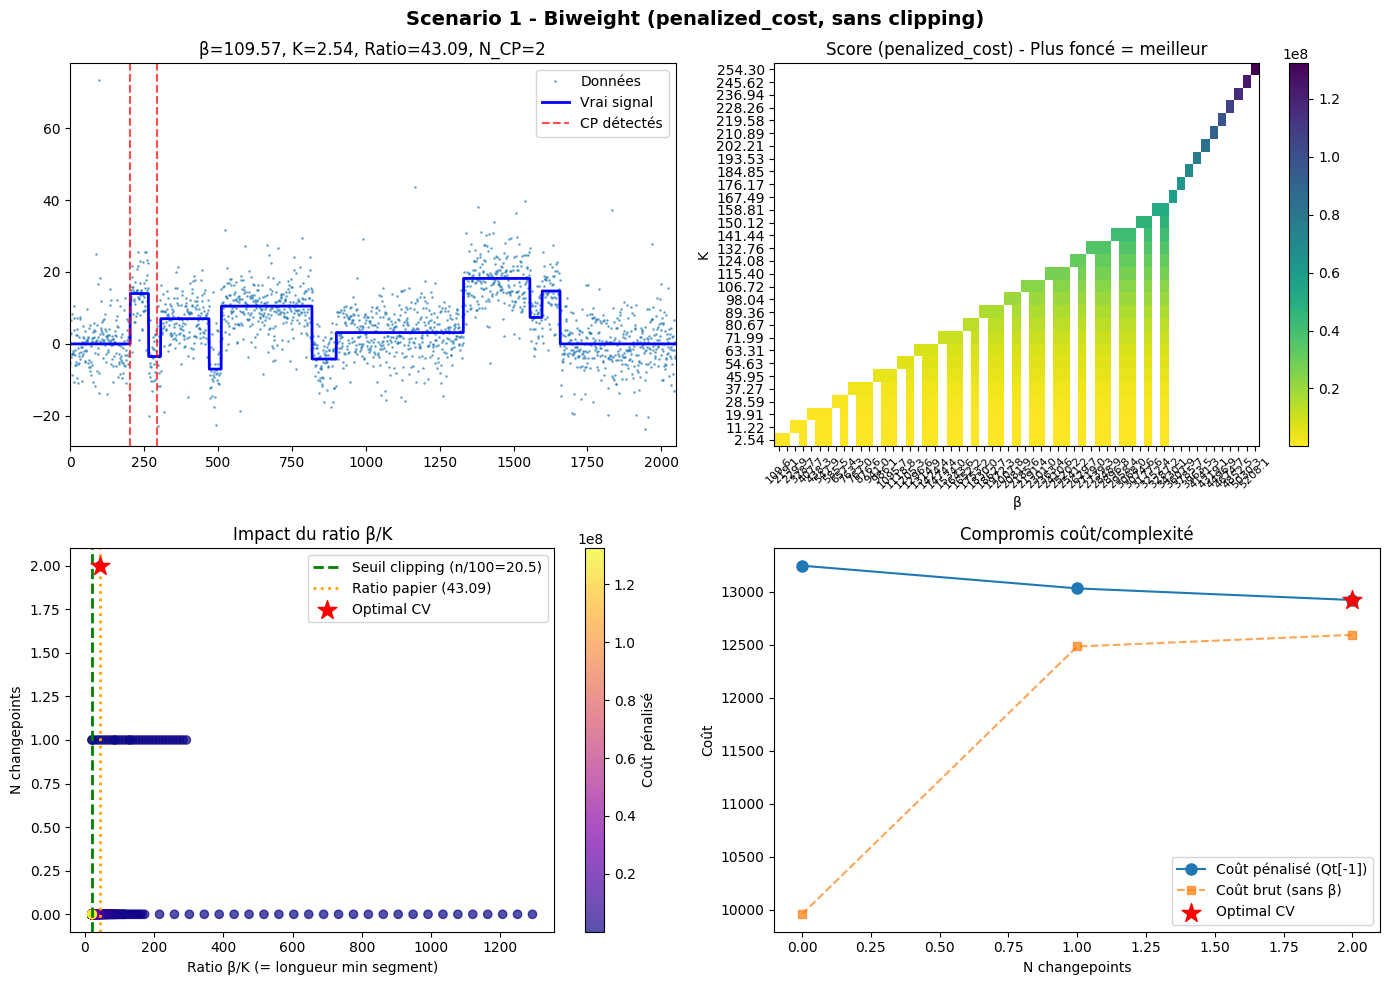


Exploration de 30 × 30 = 900 combinaisons...


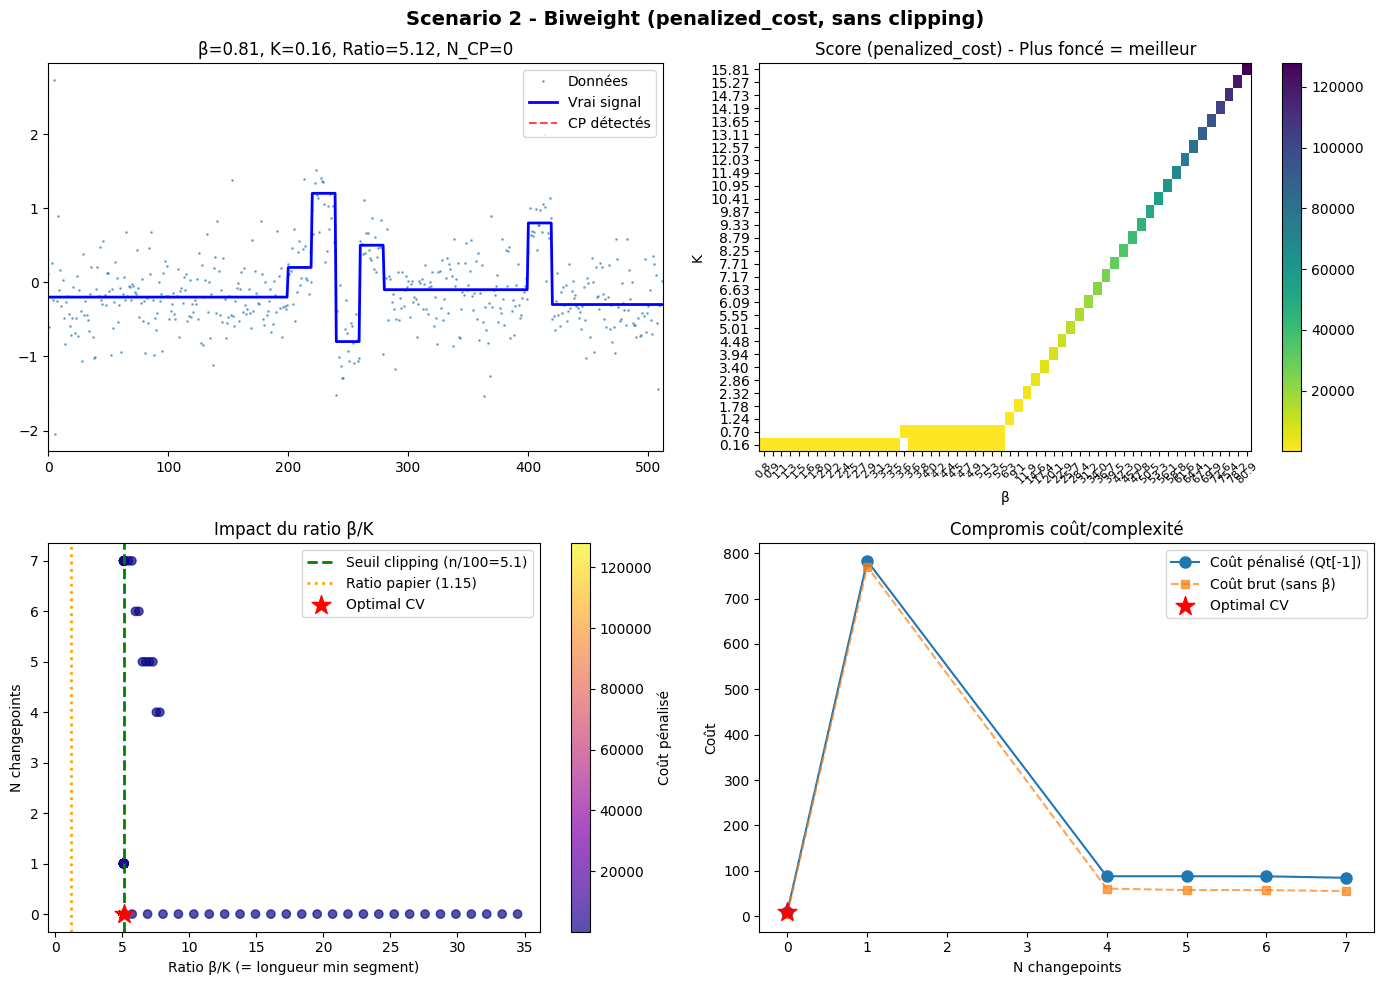


Exploration de 30 × 30 = 900 combinaisons...


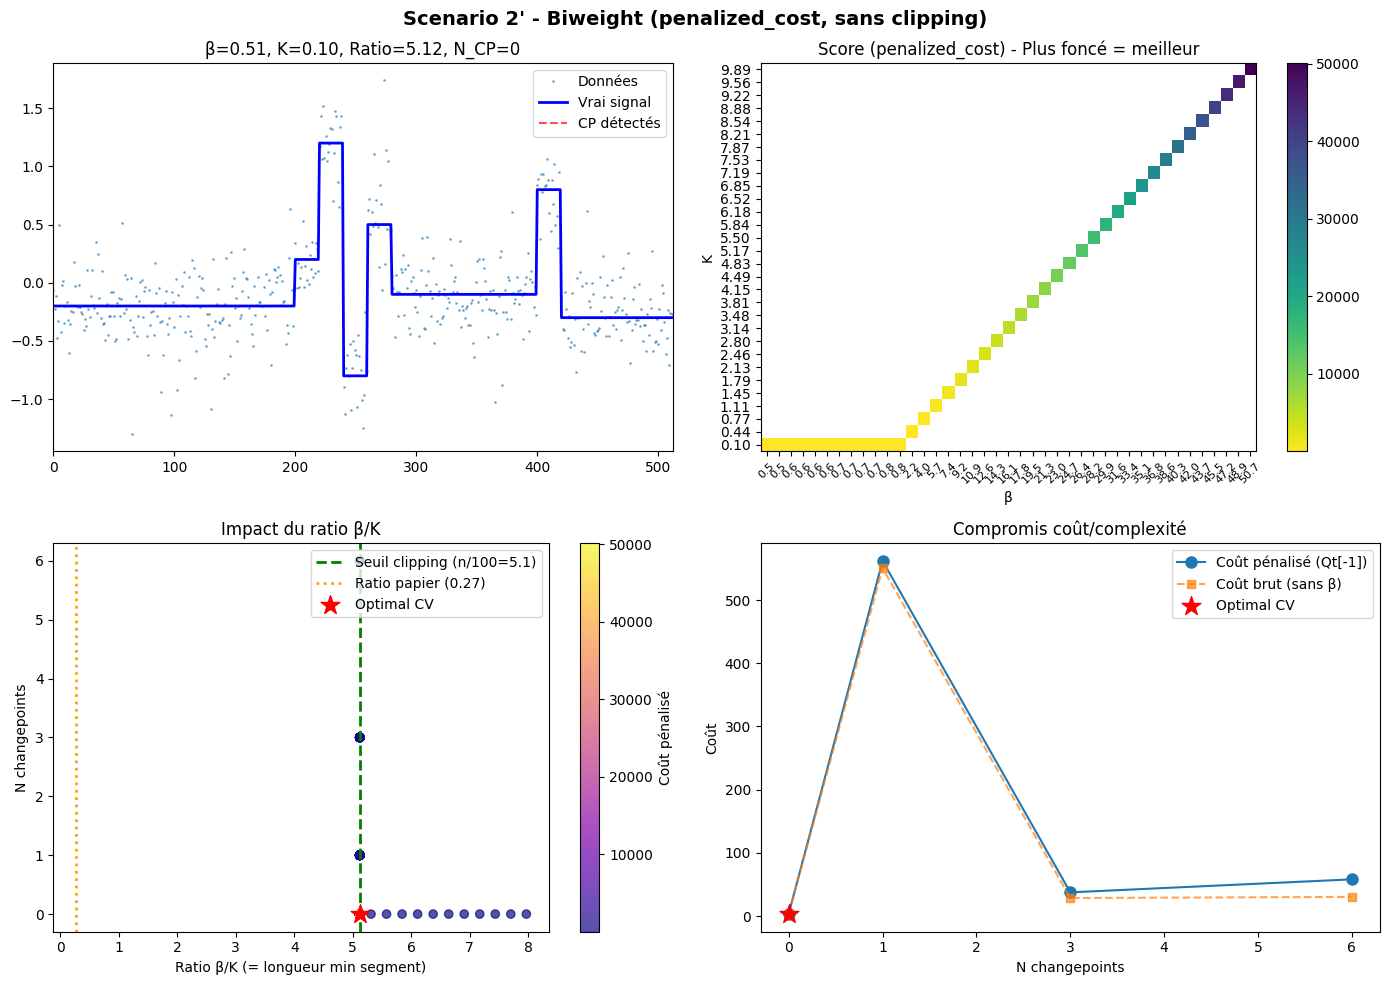


Exploration de 30 × 30 = 900 combinaisons...


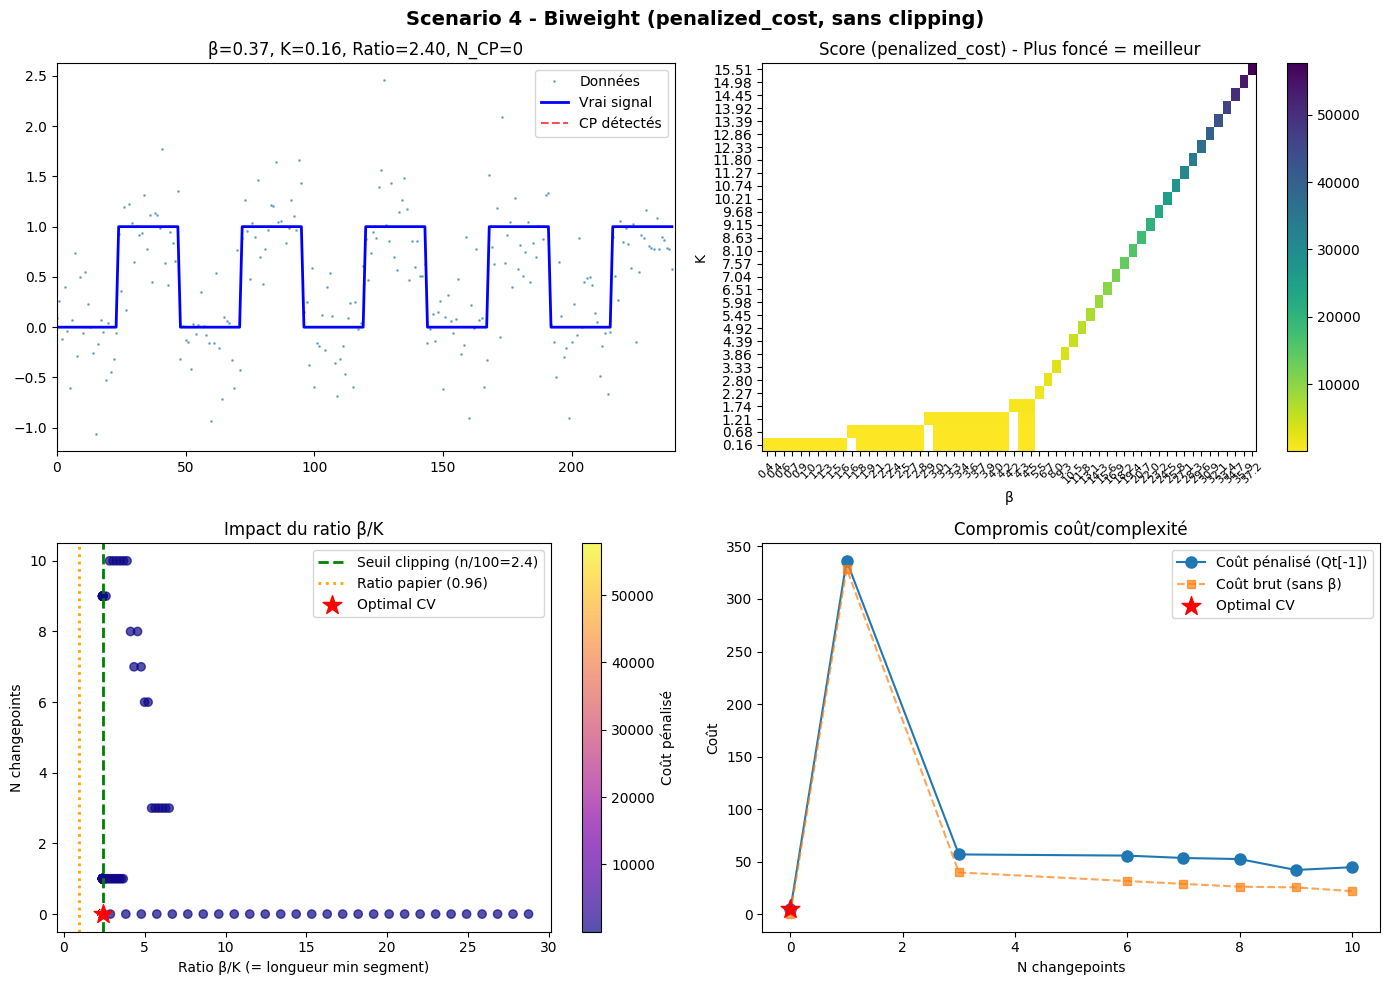


Exploration de 30 × 30 = 900 combinaisons...


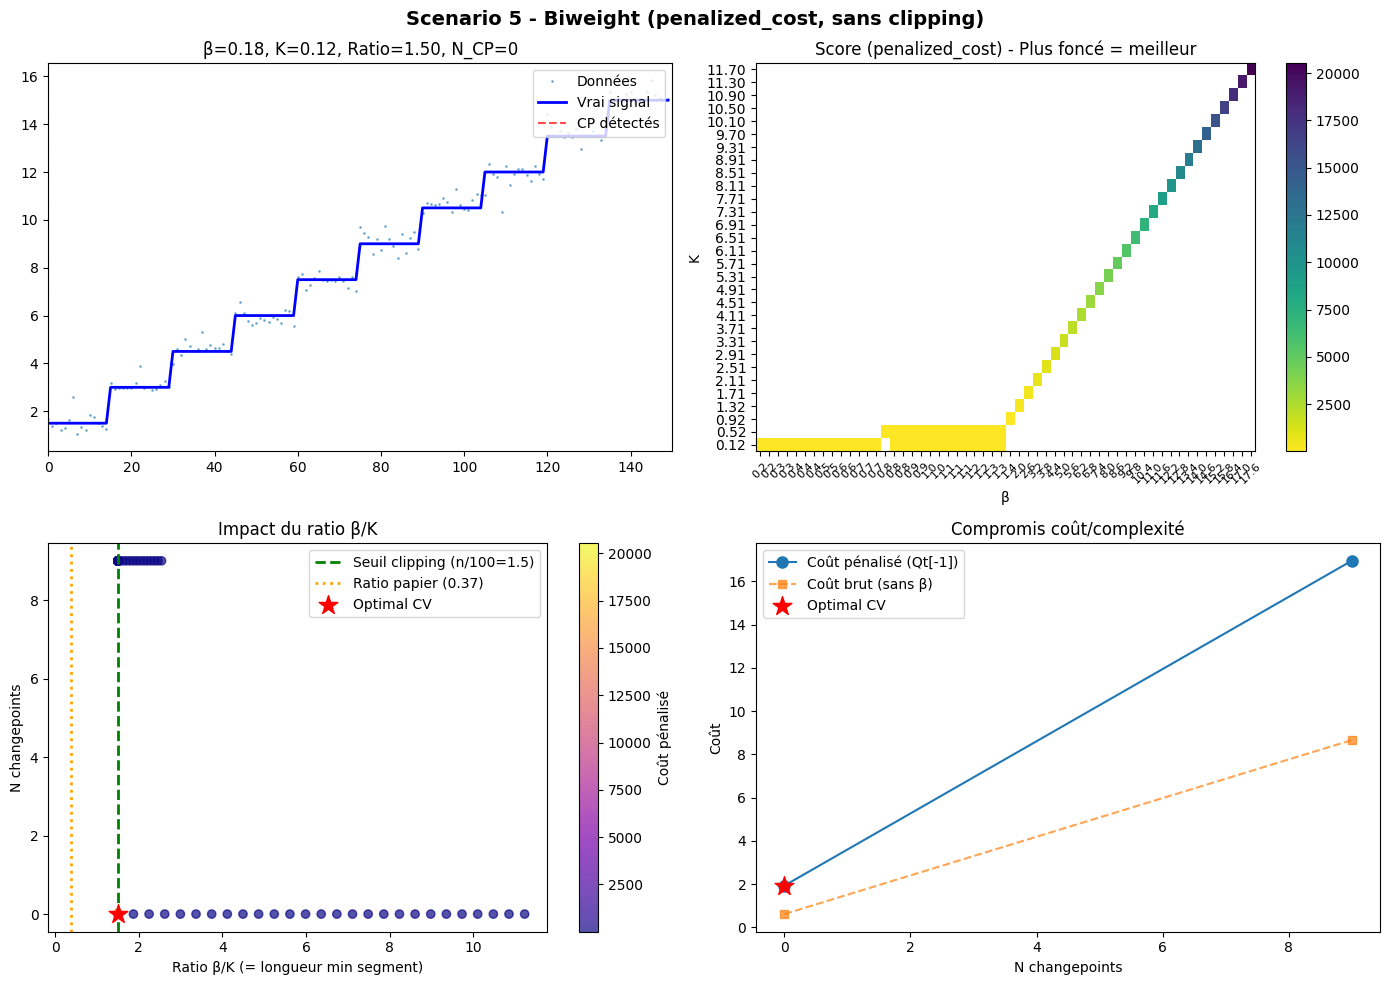

In [20]:
for scenario in ["Scenario 1", "Scenario 2", "Scenario 2'","Scenario 4", "Scenario 5"]:
    y_scn = data[scenario]
    sig_scn = true_signals[scenario]



    # CV avec critère penalized_cost (le coût pénalisé du papier)
    cv_s3_penalized = cv_biweight_paper(
        y=y_scn,
        true_signal=sig_scn,
        criterion='penalized_cost',  # Utilise Qt[-1] = Σ C(seg) + (m+1)β
        apply_clipping=True,
        verbose=True
    )

    plot_cv_biweight_results(cv_s3_penalized, y_scn, sig_scn, 
                            f"{scenario} - Biweight (penalized_cost, sans clipping)")

In [8]:
df = pd.read_csv("FRED_InterestRate_Data.csv",index_col=0)
df.index = pd.to_datetime(df.index)
df.head()

,T10Y2Y,T10Y3M,T10YFF,T5YFF,T1YFF,AAA10Y,BAA10Y,BAAnetAAA,T10YIE,T5YIE,T5YIFR
1962-01-02,NaN,NaN,1.31,1.13,0.47,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-03,NaN,NaN,1.53,1.37,0.74,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-04,NaN,NaN,1.24,1.11,0.49,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-05,NaN,NaN,1.52,1.39,0.76,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df.columns

Index(['T10Y2Y', 'T10Y3M', 'T10YFF', 'T5YFF', 'T1YFF', 'AAA10Y', 'BAA10Y',
       'BAAnetAAA', 'T10YIE', 'T5YIE', 'T5YIFR'],
      dtype='object')

0
1
2
3
4
5
6
7
8
9
10


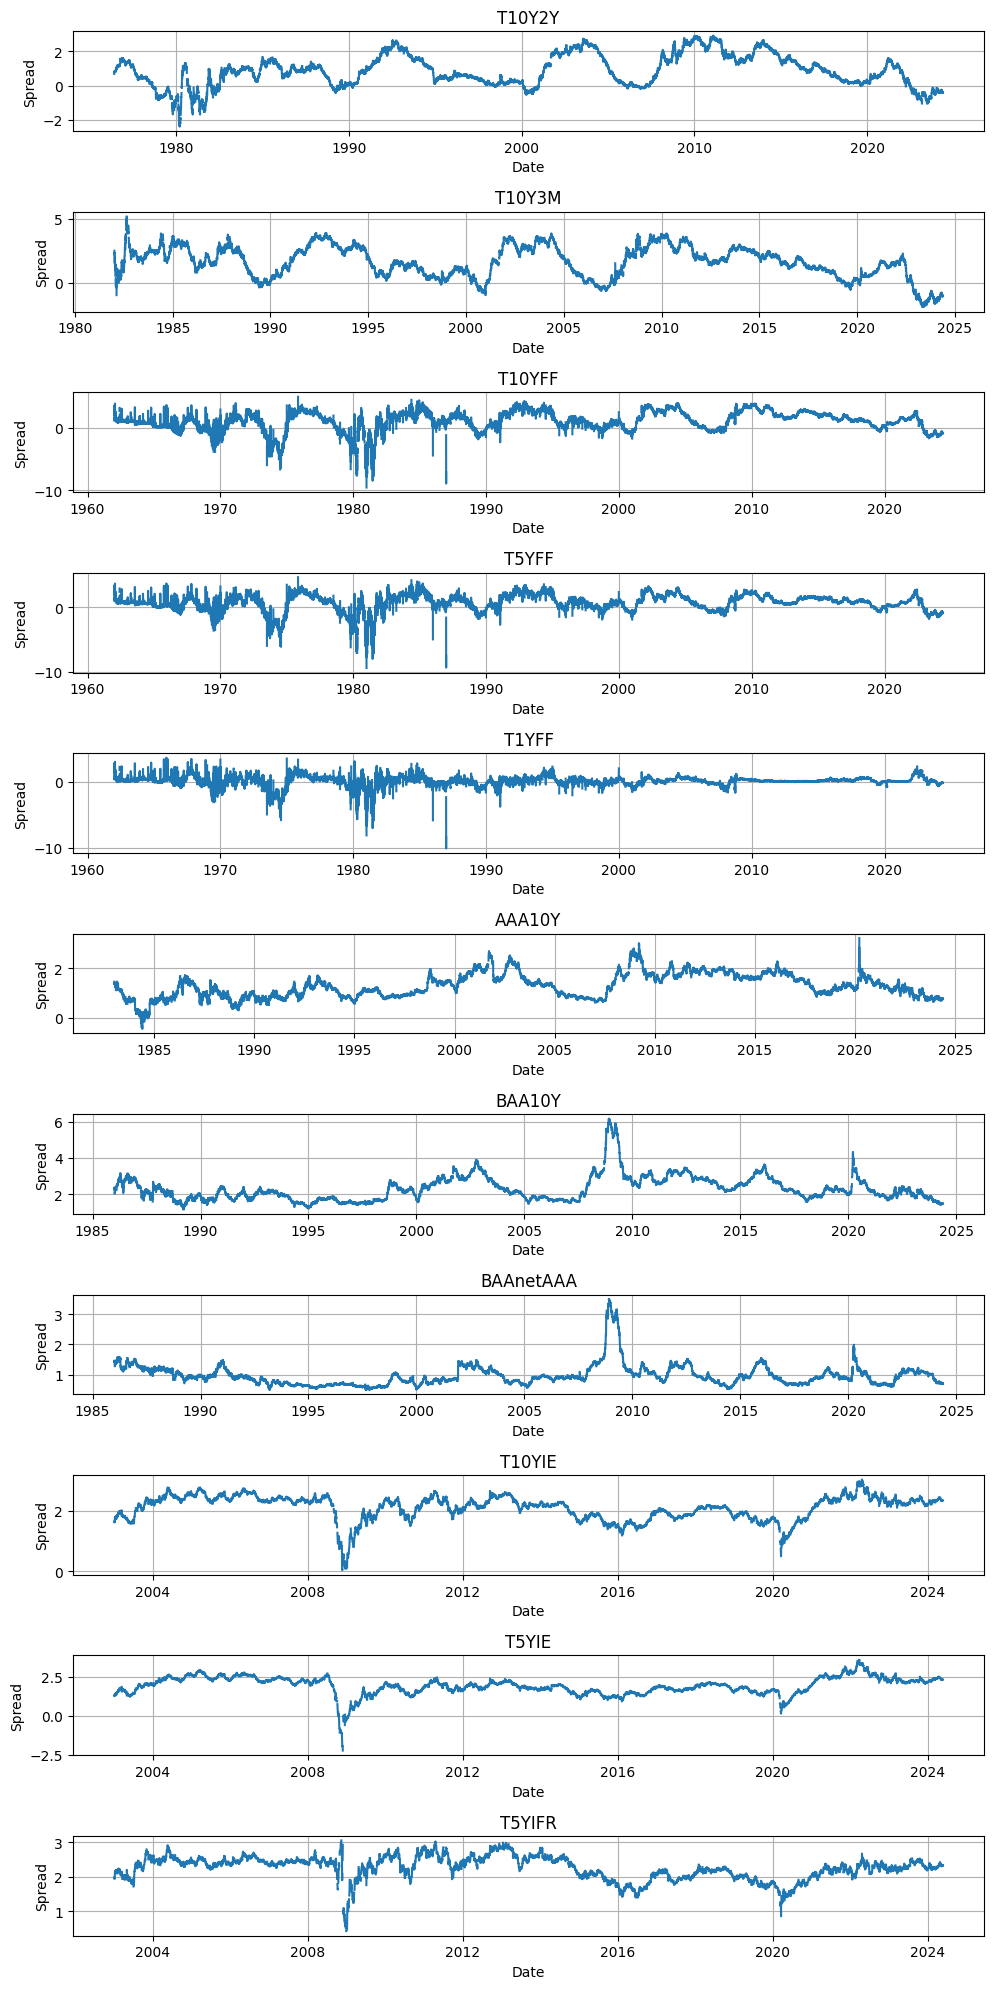

In [13]:
fig, ax = plt.subplots(len(df.columns),figsize=(10,20))
for i,column in enumerate(df.columns):
    print(i)
    ax[i].plot(df.index,df[column])
    ax[i].set_title(column)
    ax[i].set_xlabel("Date")    
    ax[i].set_ylabel("Spread")
    ax[i].grid()

plt.tight_layout()
plt.show()

The spreads in this dataset are the following:
### Recession/economic cycle indicators:
- T10Y2Y: 10 year treasury constant maturity rate minus 2 years treasury rate. An indicator of economic recession: usually the 10 year rate is above the 2 year rate, if the spread becomes negative this is a sign of recession. 
- T10Y3M: 10 year rate minus 3 months rate. Another recession indicator. 

### Monetary policy indicators:
- T10YFF: 10 year treasury rate - fed fund rate. When the spread is negative, short term rates chosen by the central bank are higher than what the market expects: this is a sign of restrictive monetary policy. 
- T5YFF, T1YFF: same but with 5 years and 1 year treasury rate. 

### Financial stress indicators:
- AAA10Y and BAA10Y: corporate credit risk: difference between AAA/BAA corporate bonds and 10 year US treasury bonds. This spread measures the fear on the US debt market. 
- BAAnetAAA: yield of AAA bonds - yield of BAA bonds. It is a credit spread representing how much investors are willing to take risk when investing in corporate bonds. If the spread increases, it means that investors are afraid of risky companies solvability. 

### Inflation indicators:
- T10YIE: 10 year breakeven inflation rate: represents markets expectations of average annual inflation rate for the 10 next years. 
- T5YIE: same but for 5 years expectations.